# Multivariate Non-parametric Regression
Spring 2019 AME-70790 Final Project

Nicholas Geneva (ngeneva@nd.edu)

Reference: Wand, M. P., & Jones, M. C. (1994). Kernel smoothing. Chapman and Hall/CRC.
___
Thus far we have presented implementation of local polynomial models for univariate cases, however to extend this method to a multivariate problem we will need to use a multivariate version of Taylor expansion:
    $$\begin{gather}
    \mathcal{L} = \sum_{i=1}^{n}\left(t_{i}-m_{w}(x_{i}, y_{i})\right)^{2},\\
    m_{w}(x_{i}, y_{i})\approx m(x,y)+m_{x}(x_{i}-x)+m_{y}(y_{i}-y)+m_{xy}(x_{i}-x)(y_{i}-y)+\frac{m_{xx}}{2}(x_{i}-x)^{2}+\frac{m_{yy}}{2}(y_{i}-y)^{2}+...,
    \end{gather}$$
where $t_{i}$ is the target value and $m_{w}(x_{i}, y_{i})$ is the local estimator we would like to find.
While a little more complex for larger polynomials, for local linear regression the loss function is:
    $$\mathcal{L} = \sum_{i=1}^{n}\left(t_{i}-\beta_{0} + \beta_{1}(x_{i}-x) + \beta_{2}(y_{i}-y)\right)^{2}K_{h}(x_{i}-x, y_{i}-y).$$
The closed-form solution of the estimator is still consistent with the univariate version:
$$\hat{m}(x) = \textbf{e}^{T}\left(\textbf{X}_{x}^{T}\textbf{W}_{x}\textbf{X}_{x}\right)^{-1}\textbf{X}_{x}^{T}\textbf{W}_{x}\textbf{Y},$$
however the $\textbf{X}$ has additional basis components present due to the multivariate Taylor expansion.
Let us implement the multivariate local linear regression for the classical bi-model Franke function originally proposed by [Franke (1979)](https://apps.dtic.mil/docs/citations/ADA081688):
    $$\begin{multline}
    f(\textbf{x})=0.75\exp\left\{-\frac{(9x_{1}-2)^{2}}{4}-\frac{(9x_{2}-2)^{2}}{4}\right\}\\
    +0.75\exp\left\{-\frac{(9x_{1}+1)^{2}}{49}-\frac{(9x_{2}+1)^{2}}{10}\right\}+0.5\exp\left\{-\frac{(9x_{1}-7)^{2}}{4}-\frac{(9x_{2}-3)^{2}}{4}\right\}\\
    -0.2\exp\left\{-(9x_{1}-4)^{2}-(9x_{2}-7)^{2}\right\},
    \end{multline}$$
Similar to the one dimensional problems, we will add some output wise noise on the observations:
    $$y_{i}=m(x_{i})+0.075\epsilon_{i},\quad \epsilon_{i}\sim\mathcal{N}(0,1).$$

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

In [56]:
plt.close("all")
np.random.seed(123)
ntrain = 200 # Number of training points

def franke(x1, x2):
    # Franke function with x1, x2 are n dimensional vectors
    f = 0.75*np.exp(-(9*x1-2)**2/4.0-(9*x2-2)**2/4.0) + 0.75*np.exp(-(9*x1+1)**2/49.0-(9*x2+1)**2/10) \
        + 0.5*np.exp(-(9*x1-7)**2/4.0-(9*x2-3)**2/4.0) - 0.2*np.exp(-(9*x1-4)**2-(9*x2-7)**2)
    return f

# Generate training data
xt = np.stack([np.random.rand(ntrain), np.random.rand(ntrain)], axis=0)
Y = franke(xt[0], xt[1]) + 0.075*np.random.randn(ntrain)

For the kernel function we will use the standard multivariate Gaussian kernel:
    $$K(\textbf{x})=\mathcal{N}(\textbf{x}|0,H), \quad H=\left[\begin{matrix} 0.1 & 0 \\ 0 & 0.1 \end{matrix}\right].$$

In [59]:
H = np.array([[0.1**2,0],[0,0.1**2]]) # Kernel Bandwidth

# Predict
n_pred = 50
x1, x2 = np.meshgrid(np.linspace(0,1,n_pred), np.linspace(0,1,n_pred))
x_pred = np.stack([np.reshape(x1, (-1)), np.reshape(x2, (-1))], axis=0)
betas = np.zeros((3,x_pred.shape[1]))
for i, x0 in enumerate(x_pred.T):
    # Solve for betas
    X = np.stack([np.ones(xt.shape[1]), xt[0]-x0[0], xt[1]-x0[1]], axis=1)
    W = np.diag(multivariate_normal.pdf(xt.T-x0, cov=H))
    betas[:,i] = np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(Y)

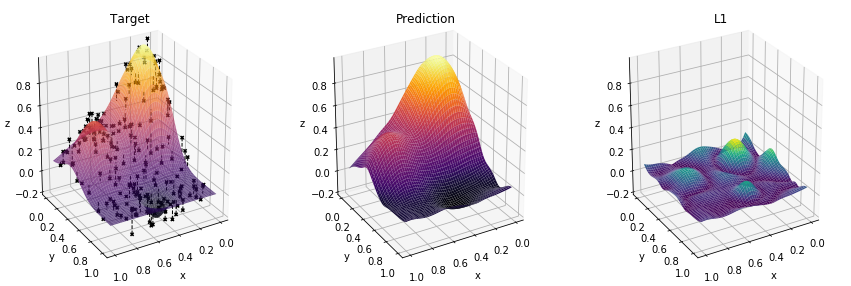

In [112]:
fig = plt.figure(figsize=(15,5))
ax = []
ax.append(plt.subplot2grid((1, 3), (0, 0), projection='3d'))
ax.append(plt.subplot2grid((1, 3), (0, 1), projection='3d'))
ax.append(plt.subplot2grid((1, 3), (0, 2), projection='3d'))

x, y = np.meshgrid(np.linspace(0,1,200), np.linspace(0,1,200))
z = np.reshape(franke(np.reshape(x, (-1)), np.reshape(y, (-1))), (200, 200))
# Appearently matplotlib sucks at 3d plotting and zorders are not fixable
ax[0].plot_surface(x, y, z, cmap=cm.inferno, alpha=0.7)
ax[0].scatter(xt[0], xt[1], Y, s=10, c='k', marker='x', alpha=1.0)
Yf = franke(xt[0], xt[1])
for i in range(ntrain):
    ax[0].plot([xt[0,i], xt[0,i]], [xt[1,i], xt[1,i]], [Y[i], Yf[i]], '--', c='k', linewidth=1.0)

zpred = np.reshape(betas[0], (n_pred, n_pred))
ax[1].plot_surface(x1, x2,  zpred, cmap=cm.inferno, alpha=1.0)

ztarget = np.reshape(franke(np.reshape(x1, (-1)), np.reshape(x2, (-1))), (n_pred, n_pred))
ax[2].plot_surface(x1, x2, np.abs(ztarget - zpred), cmap=cm.viridis, alpha=1.0)

for ax0 in ax:
    ax0.view_init(elev=25., azim=60)
    ax0.set_xlabel('x')
    ax0.set_ylabel('y')
    ax0.set_zlabel('z')
    ax0.set_zlim([-0.2,1])

ax[0].set_title('Target')
ax[1].set_title('Prediction')
ax[2].set_title('L1')
plt.show()

(Left to right) The target function with the training data points, the prediction for the local linear regression model and the L1 error.
Overall we can see the local linear regression model does very reasonable job predicting the Franke function capturing each of the three (two positive and one negative) modes.